# Лабораторная работа №2

## Задание 1

![](./1.png)

In [1]:
from random import random, uniform
from math import erf, log, exp
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy.abc import x, y
from sympy.calculus.util import continuous_domain
from scipy.stats import norm, chi2


In [2]:
inverse_function = ""
distribution_expression = ""
plt.rcParams["figure.figsize"] = (10, 30)
number_of_dots = 1000
gamma = 0.95
hypothesis_error_value = 0.05

### Нахождение обратной функции

In [3]:
def find_inverse_function(input_text): 
    global inverse_function
    ex = sympify(input_text)
    distribution_expression = ex
    extra = ex - y
    results = solve(extra, x)
    # print(results)
    is_found = False
    for result in results:
        if solve(diff(result, y) > 0, y, S.Reals) != False and continuous_domain(result, y, S.Reals).is_proper_superset(Interval(0, 1)):
            print(f"Обратная функция: {result}")
            inverse_function = lambdify(y, result)
            is_found = True
            break

    if not is_found:
        print("обратная функция не найдена")


### Генерация значений

In [4]:
def get_random_data(number_of_tests):
    global inverse_function
    result = []
    for i in range(number_of_tests):
        result.append(inverse_function(random()))
    return result

### Нахождение матожидайний

In [5]:
def get_average(data, number_of_tests):
    return sum(data) / number_of_tests

In [6]:
def get_real_average(function, limits):
    # integrate для вычисления интеграла
    return integrate(x * function, (x, limits[0], limits[1]))


### Нахождение дисперсий

In [7]:
def get_disp(data, average):
    result = 0
    for item in data:
        result += (item - average) ** 2
    return result / number_of_tests

In [8]:
def get_real_disp(function, limits, average):
    return (integrate(x ** 2 * function, (x, limits[0], limits[1])) - average ** 2).evalf()

In [9]:
def get_delta(offset):
    t = norm.ppf(gamma / 2 + 0.5)
    return t * offset / np.sqrt(number_of_tests)


In [10]:
def get_offset_delta(test_offset):
    alphas = ((1 - gamma) / 2, (1 + gamma) / 2)
    chis = (chi2.isf(alphas, number_of_tests - 1))
    temp = np.sqrt(number_of_tests - 1) * test_offset
    
    return (temp / np.sqrt(chis[0]), temp / np.sqrt(chis[1]))

-----------------------------------

In [11]:
input_text = input("Введите функцию для поиска обратной функции: ")
find_inverse_function(input_text)
number_of_tests = int(input("Введите количество тестов для функции(количество рандомных значений, которые будут сгенерированы): "))


Обратная функция: sqrt(y)


In [12]:
data = get_random_data(number_of_tests)
limits = (inverse_function(0), inverse_function(1))


In [13]:
ex = sympify(input_text)
derivative_expr = diff(ex, x)

In [14]:
mu = get_average(data, number_of_tests)
tmu = float(get_real_average(derivative_expr, limits))
disp = get_disp(data, get_average(data, number_of_tests))
tdisp = float(get_real_disp(derivative_expr, limits, float(get_real_average(derivative_expr, limits))))
standard_deviation = sqrt(get_disp(data, get_average(data, number_of_tests)))
tstandard_deviation = sqrt(float(get_real_disp(derivative_expr, limits, float(get_real_average(derivative_expr, limits)))))

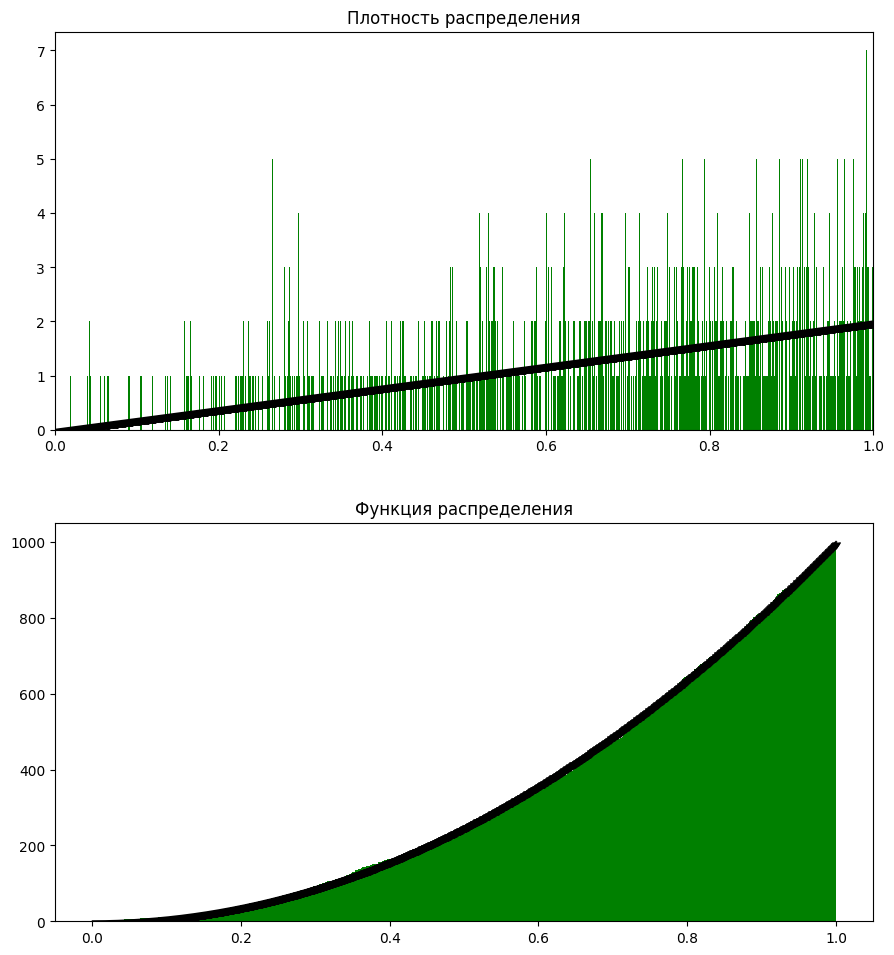

In [15]:
hist, bins = np.histogram(data, bins=number_of_dots, range=limits)
plt.subplot(6, 1, 1)  
plt.tight_layout(pad = 5)
plt.hist(x=data, color="green", bins=number_of_dots, range=limits)
plt.xlim(limits)
plt.title("Плотность распределения")
    
derivative_expr = diff(ex, x)
    
length = (limits[1] - limits[0]) / number_of_dots
dots = np.arange(limits[0] + length / 2, limits[1], length)
derivative = lambdify(x, length * number_of_tests * derivative_expr)
results = list(map(derivative, dots))
plt.plot(dots, results, marker=11, color="black")
    
extra_hist = hist.copy()
    
for i in range(1, len(hist)):
    extra_hist[i] += extra_hist[i-1]
        
plt.subplot(6, 1, 2)
ax = plt.gca()
ax.bar(bins[:-1], extra_hist, width = length, align="edge", color='green')

distribution_function = lambdify(x, number_of_tests * ex)
distribution_dots = np.arange(limits[0] + length, limits[1] + length / 10, length)
distribution_results = list(map(distribution_function, distribution_dots))
    
plt.plot(distribution_dots, distribution_results, marker=11, color="black")
plt.title("Функция распределения")
plt.show()

In [16]:
delta = get_delta(sqrt(float(get_real_disp(derivative_expr, limits, float(get_real_average(derivative_expr, limits))))))
offset_delta = get_offset_delta(sqrt(get_disp(data, get_average(data, number_of_tests))))

In [17]:
from IPython.display import HTML, display

val = np.square(offset_delta)

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4></td>" % (field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))


data = [['Опсиание', 'математическое ожидание', 'дисперсии'],
        ['Выборочно', mu, disp],
        ['Теоретическое', tmu, tdisp],
        ['Доверительный начало', mu-delta,val[0]],
        ['Доверительный конец',mu+delta,val[1]]]

display_table(data)


Опсиание,математическое ожидание,дисперсии
Выборочно,0.6695709421802025,0.055229753252592745
Теоретическое,0.6666666666666666,0.05555555555555558
Доверительный начало,0.654962233170593,0.0506891860595189
Доверительный конец,0.684179651189812,0.0604122010179702


In [18]:
k = number_of_dots - 2 - 1
critical_value = chi2.isf(hypothesis_error_value, k)
normal_value = 0
    
for i in range(number_of_dots):
    normal_value += np.square(hist[i] - results[i]) / results[i]

In [19]:
result_for_print = "принимаем" if normal_value < critical_value else "отвергаем"
data1 = [['Описание', 'Значение'],
         ["Критический кси-квадрат",critical_value],
         ["Кси-квадрат выборки",normal_value],
         ["Гипотезу согласия",result_for_print]]

display_table(data1)
    

Описание,Значение
Критический кси-квадрат,1071.568999044425
Кси-квадрат выборки,1031.255241476942
Гипотезу согласия,принимаем


## Задание 2 (Геометрическое распределение)

![](./2.png)

In [20]:
inverse_function = ""
distribution_expression = ""
plt.rcParams["figure.figsize"] = (10, 30)
max_value1 = 40
gamma1 = 0.95
number_of_dots1 = 20
hypothesis_error_value1 = 0.05

In [21]:
def get_random1():
    random_number = random()
    
    for i in range(max_value1):
        probability = p_prob1 * (1 - p_prob1) ** i
        
        if random_number < probability:
            return i + 1
        
        random_number -= probability
        
    return max_value1

In [22]:
def get_random_data1():
    result = []
    
    for i in range(number_of_tests1):
        result.append(get_random1())
    
    return result

In [23]:
def get_average1(data):
    return sum(data1) / number_of_tests1

def get_real_average1():
    return 1 / p_prob1

In [24]:
def get_real_disp1():
    return (1 - p_prob1) / np.square(p_prob1)

def get_disp1(data, average):
    result = 0
    
    for item in data:
        result += (item - average) ** 2
        
    return result / number_of_tests1


In [25]:
def get_delta1(offset):
    t = norm.ppf(gamma1 / 2 + 0.5)
    return t * offset / np.sqrt(number_of_tests1)

def get_offset_delta1(test_offset):
    alphas = ((1 - gamma1) / 2, (1 + gamma1) / 2)
    chis = (chi2.isf(alphas, number_of_tests1 - 1))
    corrected_offset = sqrt((test_offset ** 2) * number_of_tests1 / (number_of_tests1 - 1))
    temp = np.sqrt(number_of_tests1 - 1) * corrected_offset
    
    return (temp / np.sqrt(chis[0]), temp / np.sqrt(chis[1]))


In [26]:

def get_offset_delta1(test_offset):
    alphas = ((1 - gamma1) / 2, (1 + gamma1) / 2)
    chis = (chi2.isf(alphas, number_of_tests1 - 1))
    corrected_offset = sqrt((test_offset ** 2) * number_of_tests1 / (number_of_tests1 - 1))
    temp = np.sqrt(number_of_tests1 - 1) * corrected_offset
    
    return (temp / np.sqrt(chis[0]), temp / np.sqrt(chis[1]))


In [27]:
number_of_tests1 = int(input("Введите количество тестов для функции(количество рандомных значений, которые будут сгенерированы): "))
p_prob1 = float(input("Введите вероятность: "))

In [28]:
data1 = get_random_data1()
mathu1 = get_average1(data1)
tmathu1 = get_real_average1()
disp1 = get_disp1(data1, get_average1(data1))
tdisp1 = get_real_disp1()
standard_deviation1 = sqrt(disp1)
tstandard_deviation1 = sqrt(tdisp1)
deltaone = get_delta1(tstandard_deviation1)
offset_delta1 = get_offset_delta1(standard_deviation1)

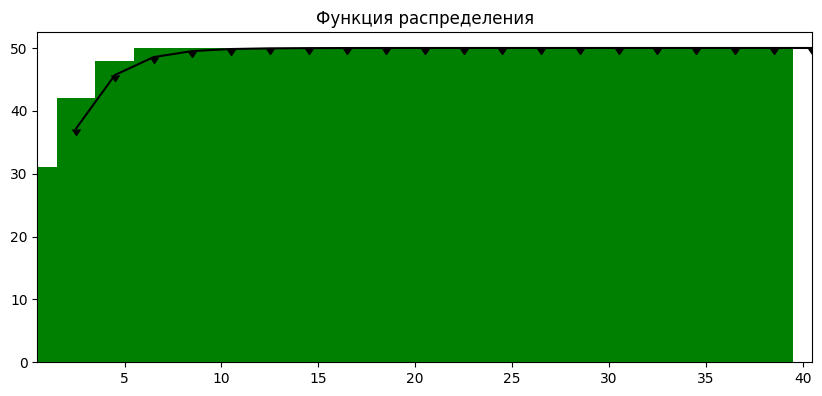

In [29]:
limits = (0.5, max_value1 + 0.5)
hist, bins = np.histogram(data1, bins=number_of_dots1, range=limits)

length = max_value1 / number_of_dots1
dots = np.arange(0.5 * (length + 1), max_value1 + length / 2, length)
derivative = lambdify(x, integrate(number_of_tests1 * p_prob1 * ((1 - p_prob1) ** (x - 1)), (x, x - length / 2, x + length / 2)))
results = list(map(derivative, dots))

plt.subplot(6, 1, 2)
        
extra_hist = hist.copy()
    
for i in range(1, len(hist)):
    extra_hist[i] += extra_hist[i-1]
    
ax = plt.gca()
ax.bar(bins[:-1], extra_hist, width = length,  color = "green")
plt.xlim(limits)
    
distribution_function = lambdify(x, number_of_tests1 * (1 - (1 - p_prob1) ** x))
distribution_dots = np.arange(limits[0] + length, limits[1] + length / 10, length)
    
distribution_results = list(map(distribution_function, distribution_dots))
plt.plot(distribution_dots, distribution_results, marker=11, color="black")
plt.title("Функция распределения")
plt.show()

In [30]:
k = number_of_dots1 - 2 - 1
critical_value = chi2.isf(hypothesis_error_value1, k)
normal_value = 0
    
for i in range(number_of_dots1):
    normal_value += np.square(hist[i] - results[i]) / results[i]
    

In [31]:
from IPython.display import HTML, display

val = np.square(offset_delta1)

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4></td>" % (field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))


data = [['Опсиание', 'математическое ожидание', 'дисперсии'],
        ['Выборочно', mathu1, disp1],
        ['Теоретическое', tmathu1, tdisp1],
        ['Доверительный начало', mathu1-deltaone,val[0]],
        ['Доверительный конец',mathu1+deltaone,val[1]]]
display_table(data)


Опсиание,математическое ожидание,дисперсии
Выборочно,2.7,3.01
Теоретическое,2.380952380952381,3.2879818594104315
Доверительный начало,2.19739385367637,2.14319036268410
Доверительный конец,3.20260614632363,4.76946279284427


In [32]:
result_for_print = "принимаем" if normal_value < critical_value else "отвергаем"
data1 = [['Описание', 'Значение'],
         ["Критический кси-квадрат",critical_value],
         ["Кси-квадрат выборки",normal_value],
         ["Гипотезу согласия",result_for_print]]

display_table(data1)
    

Описание,Значение
Критический кси-квадрат,27.587111638275335
Кси-квадрат выборки,2.5345275297997296
Гипотезу согласия,принимаем
